In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
!pip install cython

In [3]:
%load_ext Cython

In [4]:
%%cython -a
cimport libc.math

def csin(double x):
    return libc.math.sin(x)

In [5]:
%%cython 
cimport libc.math

def square_sin(double x):
    cdef double x_square = x * x 
    return libc.math.sin(x_square)



In [6]:
square_sin(5)

-0.13235175009777303

In [8]:
%%cython 
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
import numpy as np
import matplotlib.pyplot as plt

def plot_julia_set(width, height, x_min, x_max, y_min, y_max, c_real, c_imag, max_iter):
    julia_set = np.zeros((width, height), dtype=np.double)
    cdef double z_real, z_imag, z_real_new, z_imag_new
    cdef int x, y, i
    for x in range(width):
        for y in range(height):
            z_real = x_min + x * (x_max - x_min) / (width - 1)
            z_imag = y_min + y * (y_max - y_min) / (height - 1)
            z_real_new = z_real
            z_imag_new = z_imag
            for i in range(max_iter):
                z_real = z_real_new
                z_imag = z_imag_new
                z_real_new = z_real * z_real - z_imag * z_imag + c_real
                z_imag_new = 2 * z_real * z_imag + c_imag
                if z_real_new * z_real_new + z_imag_new * z_imag_new > 4:
                    break
            julia_set[x, y] = i

    plt.figure(figsize=(7,7), dpi=100)
    plt.imshow(julia_set, cmap='jet', aspect='equal')
    plt.xlim(0, width)
    plt.ylim(0, height)
    plt.title(f'Julia Set for c = {c_real} + {c_imag}i')
    plt.show()



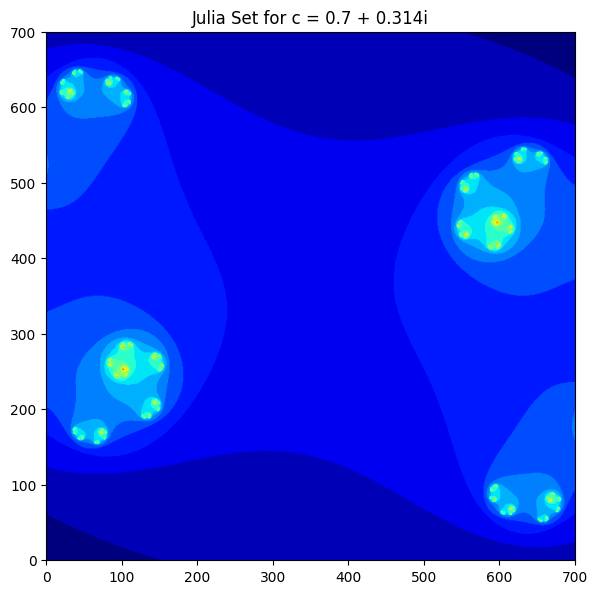

In [10]:
plot_julia_set(700, 700, -1, 1, -1, 1, 0.7, 0.314, 100)


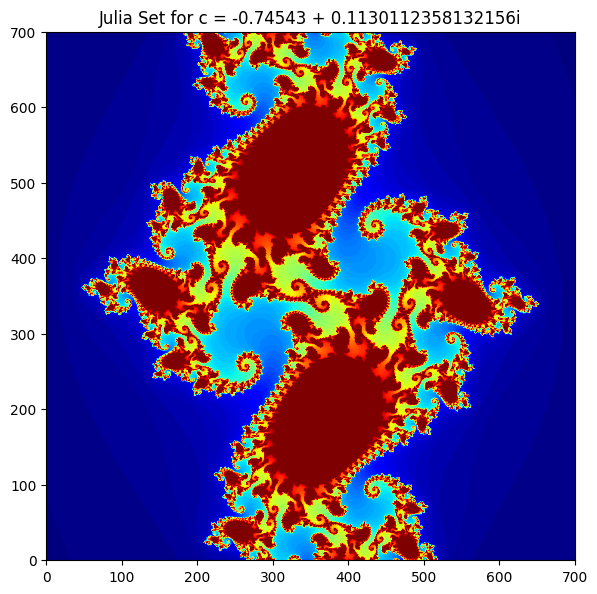

In [38]:
plot_julia_set(700, 700, -1, 1, -1, 1, -0.74543, 0.113011235813215589, 100)


In [77]:
plot_julia_set(500, 500, -1, 1, -1, 1, 0.2973525628, 0.001, 100)


Traceback (most recent call last):
  Input In [77] in <cell line: 1>
    plot_julia_set(500, 500, -1, 1, -1, 1, 0.2973525628, 0.001, 100)
NameError: name 'plot_julia_set' is not defined

Use %tb to get the full traceback.


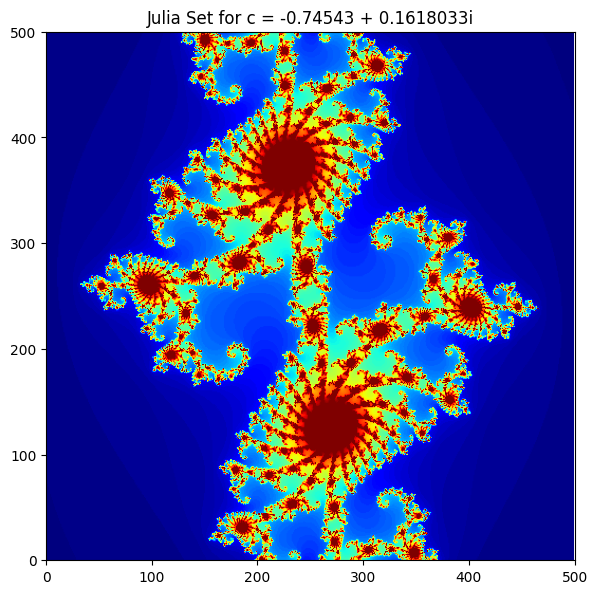

In [475]:
plot_julia_set(500, 500, -1, 1, -1, 1, -0.74543, 0.1618033, 100)


In [ ]:
!pip install Pillow
from PIL import Image

if __name__ == "__main__":
    w, h, zoom = 800,600,1
    bitmap = Image.new("RGB", (w, h), "white")
    pix = bitmap.load()

    cX, cY = -0.7, 0.27015
    moveX, moveY = 0.0, 0.0
    maxIter = 255
 
    for x in range(w):
        for y in range(h):
            zx = 1.5*(x - w/2)/(0.5*zoom*w) + moveX
            zy = 1.0*(y - h/2)/(0.5*zoom*h) + moveY
            i = maxIter
            while zx*zx + zy*zy < 4 and i > 1:
                tmp = zx*zx - zy*zy + cX
                zy,zx = 2.0*zx*zy + cY, tmp
                i -= 1
            # convert byte to RGB (3 bytes), kinda magic to get nice colors
            pix[x , y] = (i << 21) + (i << 10) + i*8
 
    bitmap.show()

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening '/tmp/tmpakagedp9.PNG'


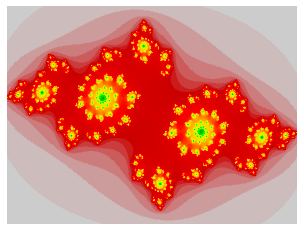

Execution time: 2.7409732140076812 seconds


In [58]:
"""
This solution is an improved version of an efficient Julia set solver
from:
'Bauckhage C. NumPy/SciPy Recipes for Image Processing:
 Creating Fractal Images. researchgate. net, Feb. 2015.'
"""
import itertools
from functools import partial
from numbers import Complex
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np


def douady_hubbard_polynomial(z: Complex,
                              *,
                              c: Complex):
    """
    Monic and centered quadratic complex polynomial
    https://en.wikipedia.org/wiki/Complex_quadratic_polynomial#Map
    """
    return z ** 2 + c


def julia_set(*,
              mapping: Callable[[Complex], Complex],
              min_coordinate: Complex,
              max_coordinate: Complex,
              width: int,
              height: int,
              iterations_count: int = 256,
              threshold: float = 2.) -> np.ndarray:
    """
    As described in https://en.wikipedia.org/wiki/Julia_set
    :param mapping: function defining Julia set
    :param min_coordinate: bottom-left complex plane coordinate
    :param max_coordinate: upper-right complex plane coordinate
    :param height: pixels in vertical axis
    :param width: pixels in horizontal axis
    :param iterations_count: number of iterations
    :param threshold: if the magnitude of z becomes greater
    than the threshold we assume that it will diverge to infinity
    :return: 2D pixels array of intensities
    """
    imaginary_axis, real_axis = np.ogrid[
                        min_coordinate.imag: max_coordinate.imag: height * 1j,
                        min_coordinate.real: max_coordinate.real: width * 1j]
    complex_plane = real_axis + 1j * imaginary_axis

    result = np.ones(complex_plane.shape)

    for _ in range(iterations_count):
        mask = np.abs(complex_plane) <= threshold
        if not mask.any():
            break
        complex_plane[mask] = mapping(complex_plane[mask])
        result[~mask] += 1

    return result


if __name__ == '__main__':
    mapping = partial(douady_hubbard_polynomial,
                      c=-0.74543 + 0.314156j)  # type: Callable[[Complex], Complex]

    image = julia_set(mapping=mapping,
                      min_coordinate=-1.5 - 1j,
                      max_coordinate=1.5 + 1j,
                      width=800,
                      height=600)
    plt.axis('off')
    plt.imshow(image,
               cmap='nipy_spectral',
               origin='lower')
    plt.show()
    
import timeit

mapping = partial(douady_hubbard_polynomial, 
                      c=-0.74543 + 0.314156j)

execution_time = timeit.timeit(lambda: julia_set(mapping=mapping,
                      min_coordinate=-1.5 - 1j,
                      max_coordinate=1.5 + 1j,
                      width=800,
                      height=600), number=1)

print(f"Execution time: {execution_time} seconds")


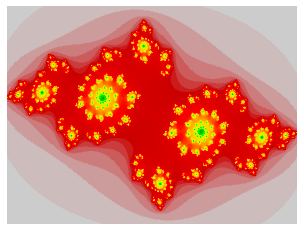

Execution time: 3.0206182000110857 seconds


In [59]:
"""
This solution is an improved version of an efficient Julia set solver
from:
'Bauckhage C. NumPy/SciPy Recipes for Image Processing:
 Creating Fractal Images. researchgate. net, Feb. 2015.'
"""
import itertools
from functools import partial
from numbers import Complex
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np


def douady_hubbard_polynomial(z: Complex,
                              *,
                              c: Complex):
    """
    Monic and centered quadratic complex polynomial
    https://en.wikipedia.org/wiki/Complex_quadratic_polynomial#Map
    """
    return z ** 2 + c

def julia_set(*,
              mapping: Callable[[np.complex128], np.complex128],
              min_coordinate: np.complex128,
              max_coordinate: np.complex128,
              width: int,
              height: int,
              iterations_count: int = 256,
              threshold: float = 2.) -> np.ndarray:
    """
    As described in https://en.wikipedia.org/wiki/Julia_set
    :param mapping: function defining Julia set
    :param min_coordinate: bottom-left complex plane coordinate
    :param max_coordinate: upper-right complex plane coordinate
    :param height: pixels in vertical axis
    :param width: pixels in horizontal axis
    :param iterations_count: number of iterations
    :param threshold: if the magnitude of z becomes greater
    than the threshold we assume that it will diverge to infinity
    :return: 2D pixels array of intensities
    """
    imaginary_axis, real_axis = np.ogrid[
                        min_coordinate.imag: max_coordinate.imag: height * 1j,
                        min_coordinate.real: max_coordinate.real: width * 1j]
    complex_plane = real_axis + 1j * imaginary_axis

    result = np.ones(complex_plane.shape, dtype=np.uint8)

    for _ in range(iterations_count):
        mask = np.less_equal(np.abs(complex_plane), threshold)
        if not np.any(mask):
            break
        complex_plane = np.where(mask, mapping(complex_plane), complex_plane)
        result[~mask] += 1

    return result

if __name__ == '__main__':
    mapping = partial(douady_hubbard_polynomial,
                      c=-0.74543 + 0.314156j)  # type: Callable[[Complex], Complex]

    image = julia_set(mapping=mapping,
                      min_coordinate=-1.5 - 1j,
                      max_coordinate=1.5 + 1j,
                      width=800,
                      height=600)
    plt.axis('off')
    plt.imshow(image,
               cmap='nipy_spectral',
               origin='lower')
    plt.show()
    
import timeit

mapping = partial(douady_hubbard_polynomial,
                      c=-0.74543 + 0.314156j)

execution_time = timeit.timeit(lambda: julia_set(mapping=mapping,
                      min_coordinate=-1.5 - 1j,
                      max_coordinate=1.5 + 1j,
                      width=800,
                      height=600), number=1)

print(f"Execution time: {execution_time} seconds")


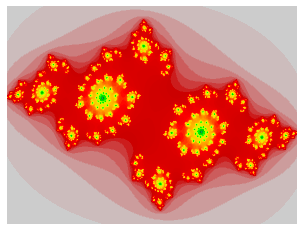

Execution time: 0.27755906400852837 seconds


In [61]:
"""
FASTEST Solution from:
https://codereview.stackexchange.com/questions/210271/generating-julia-set
"""
from functools import partial
from numbers import Complex
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np


def douady_hubbard_polynomial(z: Complex,
                              c: Complex) -> Complex:
    """
    Monic and centered quadratic complex polynomial
    https://en.wikipedia.org/wiki/Complex_quadratic_polynomial#Map
    """
    return z ** 2 + c


def julia_set(mapping: Callable[[Complex], Complex],
              *,
              min_coordinate: Complex,
              max_coordinate: Complex,
              width: int,
              height: int,
              iterations_count: int = 256,
              threshold: float = 2.) -> np.ndarray:
    """
    As described in https://en.wikipedia.org/wiki/Julia_set
    :param mapping: function defining Julia set
    :param min_coordinate: bottom-left complex plane coordinate
    :param max_coordinate: upper-right complex plane coordinate
    :param height: pixels in vertical axis
    :param width: pixels in horizontal axis
    :param iterations_count: number of iterations
    :param threshold: if the magnitude of z becomes greater
    than the threshold we assume that it will diverge to infinity
    :return: 2D pixels array of intensities
    """
    im, re = np.ogrid[min_coordinate.imag: max_coordinate.imag: height * 1j,
                      min_coordinate.real: max_coordinate.real: width * 1j]
    z = (re + 1j * im).flatten()

    live, = np.indices(z.shape)  # indexes of pixels that have not escaped
    iterations = np.empty_like(z, dtype=int)

    for i in range(iterations_count):
        z_live = z[live] = mapping(z[live])
        escaped = abs(z_live) > threshold
        iterations[live[escaped]] = i
        live = live[~escaped]
        if live.size == 0:
            break
    else:
        iterations[live] = iterations_count

    return iterations.reshape((height, width))


if __name__ == '__main__':
    mapping = partial(douady_hubbard_polynomial,
                      c=-0.74543 + 0.314156j)  # type: Callable[[Complex], Complex]

    image = julia_set(mapping,
                      min_coordinate=-1.5 - 1j,
                      max_coordinate=1.5 + 1j,
                      width=800,
                      height=600)
    plt.axis('off')
    plt.imshow(image,
               cmap='nipy_spectral_r',
               origin='lower')
    plt.show()
    
    
   
import timeit

mapping = partial(douady_hubbard_polynomial,
                      c=-0.74543 + 0.314156j)

execution_time = timeit.timeit(lambda: julia_set(mapping=mapping,
                      min_coordinate=-1.5 - 1j,
                      max_coordinate=1.5 + 1j,
                      width=800,
                      height=600), number=1)

print(f"Execution time: {execution_time} seconds")


In [63]:
!pip install opencv-python


  Using cached opencv_python-4.7.0.68-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.8 MB)


/tmp/ipykernel_59/483084958.py:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  julia_set = np.vstack(p.imap_unordered(generate_julia, ((x, y)


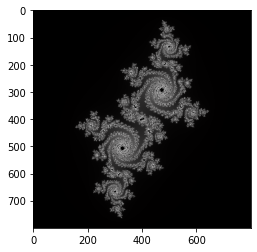

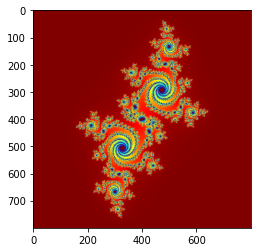

In [64]:
from itertools import product
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import cv2

# Define the seed value for the Julia set (0.6180, -0.314)
seed_value = complex(-0.512511498387847167, 0.521295573094847167)
max_iterations = 256

# Define the escape time function for the Julia set
def escape_time(c):
    z = c
    for i in range(max_iterations):
        z = z*z + seed_value
        if abs(z) > 2:
            return i, int(i*255/256), int(i*255/256), int(i*255/256)
    return max_iterations,0, 0, 0

# Define the function to generate the Julia set
def generate_julia(coord):
    x,y = coord
    julia_set = np.zeros((800, 800, 4), dtype=np.uint8)
    for x, y in product(range(x, x+800), range(y, y+800)):
        c = complex(x/256, y/256)
        julia_set[x+400, y+400] = escape_time(c)
    return julia_set

# Create a pool of worker processes
with Pool() as p:
    # Divide the x and y ranges into chunks and generate the Julia set in parallel
    julia_set = np.vstack(p.imap_unordered(generate_julia, ((x, y) 
        for x in range(-400, 400, 800) for y in range(-400, 400, 800)), chunksize=1))

# Remove the alpha channel of the image
julia_set = julia_set[:,:,:3]

# Apply jet colormap to the Julia set
jet_map = cv2.applyColorMap(julia_set, cv2.COLORMAP_JET)


#save the image using OpenCV
cv2.imwrite("julia_set.png", julia_set)
cv2.imwrite("julia_set_jet.png", jet_map)

#Show the original image
plt.imshow(julia_set)
plt.show()

#Show the jet colormapped image
plt.imshow(jet_map)
plt.show()

In [65]:
%%cython

a: cython.int = 0
for i in range(10):
    a += i
print(a)

45


In [66]:
%%cython

cdef int a = 0
for i in range(10):
    a += i
print(a)

45


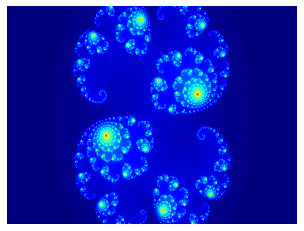

Execution time: 1.7107757419871632 seconds


In [67]:
from functools import partial
from numbers import Complex
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np


def douady_hubbard_polynomial(z: Complex,
                              c: Complex) -> Complex:
    """
    Monic and centered quadratic complex polynomial
    https://en.wikipedia.org/wiki/Complex_quadratic_polynomial#Map
    """
    return z ** 2 + c


def julia_set(mapping: Callable[[Complex], Complex],
              *,
              min_coordinate: Complex,
              max_coordinate: Complex,
              width: int,
              height: int,
              iterations_count: int = 256,
              threshold: float = 2.) -> np.ndarray:
    """
    As described in https://en.wikipedia.org/wiki/Julia_set
    :param mapping: function defining Julia set
    :param min_coordinate: bottom-left complex plane coordinate
    :param max_coordinate: upper-right complex plane coordinate
    :param height: pixels in vertical axis
    :param width: pixels in horizontal axis
    :param iterations_count: number of iterations
    :param threshold: if the magnitude of z becomes greater
    than the threshold we assume that it will diverge to infinity
    :return: 2D pixels array of intensities
    """
    im, re = np.ogrid[min_coordinate.imag: max_coordinate.imag: height * 1j,
                      min_coordinate.real: max_coordinate.real: width * 1j]
    z = (re + 1j * im).flatten()

    live, = np.indices(z.shape)  # indexes of pixels that have not escaped
    iterations = np.empty_like(z, dtype=int)

    for i in range(iterations_count):
        z_live = z[live] = mapping(z[live])
        escaped = abs(z_live) > threshold
        iterations[live[escaped]] = i
        live = live[~escaped]
        if live.size == 0:
            break
    else:
        iterations[live] = iterations_count

    return iterations.reshape((height, width))


if __name__ == '__main__':
    mapping = partial(douady_hubbard_polynomial,
                      c=0.285 + 0.01j)  # type: Callable[[Complex], Complex]

    image = julia_set(mapping,
                      min_coordinate=-1.5 - 1j,
                      max_coordinate=1.5 + 1j,
                      width=800,
                      height=600)
    plt.axis('off')
    plt.imshow(image,
               cmap='jet',
               origin='lower')
    plt.show()
    

import timeit

mapping = partial(douady_hubbard_polynomial,
                      c=-0.7 + 0.27015j)

execution_time = timeit.timeit(lambda: julia_set(mapping=mapping,
                      min_coordinate=-1.5 - 1j,
                      max_coordinate=1.5 + 1j,
                      width=800,
                      height=600), number=1)

print(f"Execution time: {execution_time} seconds")


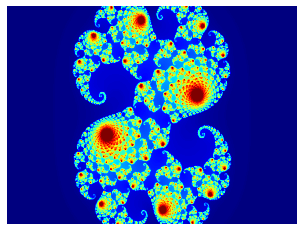

In [68]:
from functools import partial
from numbers import Complex
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np

def douady_hubbard_polynomial(z: Complex, 
                              c: Complex) -> Complex:
    return z ** 2 + c

def julia_set(mapping: Callable[[Complex], Complex],
              *,
              min_coordinate: Complex,
              max_coordinate: Complex,
              width: int,
              height: int,
              iterations_count: int = 256,
              threshold: float = 2.) -> np.ndarray:
    im, re = np.ogrid[min_coordinate.imag: max_coordinate.imag: height * 1j,
                      min_coordinate.real: max_coordinate.real: width * 1j]
    z = (re + 1j * im).flatten()

    live, = np.indices(z.shape)  # indexes of pixels that have not escaped
    iterations = np.empty_like(z, dtype=int)

    for i in range(iterations_count):
        z_live = z[live] = mapping(z[live])
        escaped = abs(z_live) > threshold
        iterations[live[escaped]] = i
        live = live[~escaped]
        if live.size == 0:
            break
    else:
        iterations[live] = iterations_count

    return iterations.reshape((height, width))

if __name__ == '__main__':
    mapping = partial(douady_hubbard_polynomial,
                      c=0.28 + 0.01j)  # type: Callable[[Complex], Complex]
    image = julia_set(mapping,
                      min_coordinate=-1.5 - 1j,
                      max_coordinate=1.5 + 1j,
                      width=800,
                      height=600)
    plt.axis('off')
    plt.imshow(image,
               cmap='jet',
               origin='lower')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

#Read the image using OpenCV
img = cv2.imread('julia_set.png')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Use Canny edge detection to find edges in the image
#edges = cv2.Canny(gray, 50, 150)
# Use Canny edge detection to find edges in the image with increased sensibility
edges = cv2.Canny(gray, 250, 1)

# Find contours in the image
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the image
for contour in contours:
    plt.plot(contour[:, 0, 0], contour[:, 0, 1], linewidth=0.729735256286)

# Show the image with the contours
plt.imshow(img)
plt.show()


In [74]:
import matplotlib.pyplot as plt

#Read the image using OpenCV
img = cv2.imread('image.png')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Use Canny edge detection to find edges in the image
#edges = cv2.Canny(gray, 50, 150)
# Use Canny edge detection to find edges in the image with increased sensibility
edges = cv2.Canny(gray, 256, 1)

# Find contours in the image
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the image
for contour in contours:
    plt.plot(contour[:, 0, 0], contour[:, 0, 1], linewidth=3.14)

# Show the image with the contours
plt.imshow(img)
plt.show()



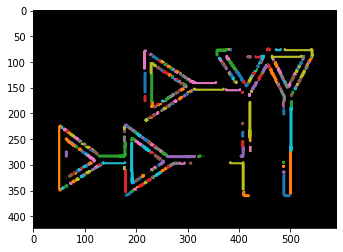

In [101]:
import matplotlib.pyplot as plt

#Read the image using OpenCV
img = cv2.imread('image.png')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Define the Sobel kernel for x and y direction
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

# Apply the Sobel kernel to the grayscale image in x and y direction
sobel_x = cv2.filter2D(gray, -1, sobel_x)
sobel_y = cv2.filter2D(gray, -1, sobel_y)

# Calculate the gradient magnitude
# Convert the edges image to type uint8
edges = cv2.convertScaleAbs(edges)


# Find contours in the image
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the image
for contour in contours:
    plt.plot(contour[:, 0, 0], contour[:, 0, 1], linewidth=2)

# Show the image with the contours
plt.imshow(img)
plt.show()


/tmp/ipykernel_59/4130560930.py:37: UserWarning: Attempting to set identical left == right == 200 results in singular transformations; automatically expanding.
  plt.xlim(200, 200)
/tmp/ipykernel_59/4130560930.py:38: UserWarning: Attempting to set identical bottom == top == 200 results in singular transformations; automatically expanding.
  plt.ylim(200, 200)


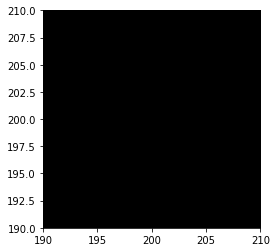

In [107]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

#Read the image using OpenCV
img = cv2.imread('el.png')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Define the Sobel kernel for x and y direction
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

# Apply the Sobel kernel to the grayscale image in x and y direction
sobel_x = cv2.filter2D(gray, -1, sobel_x)
sobel_y = cv2.filter2D(gray, -1, sobel_y)

# Calculate the gradient magnitude
edges = np.sqrt(np.square(sobel_x) + np.square(sobel_y))

# Convert the edges image to type uint8
# Convert the edges image to type uint8
edges = edges.astype(np.uint8)

# Find contours in the image
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the image
for contour in contours:
    plt.plot(contour[:, 0, 0], contour[:, 0, 1], linewidth=2)

# Show the image with the contours
plt.imshow(img)

# Set the x and y axis limits for zoom in
plt.xlim(200, 200)
plt.ylim(200, 200)

plt.show()


In [ ]:
import cv2

# Read the image using OpenCV
img = cv2.imread('el.png')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Use Canny edge detection to find edges in the image
edges = cv2.Canny(gray, 256, 1)

# Display the original image
cv2.imshow("Original Image", img)

# Display the edges of the image
cv2.imshow("Edges", edges)

# Wait for a key press before closing the window
cv2.waitKey(0)

# Close all windows
cv2.destroyAllWindows()


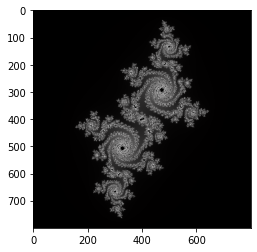

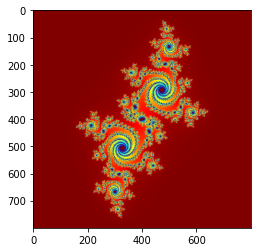

11.395394133985974


In [14]:
#Worst
import timeit
import matplotlib.pyplot as plt
import cv2
import numpy as np
from itertools import product
from multiprocessing import Pool

# Define the seed value for the Julia set (0.6180, -0.314)
seed_value = complex(-0.512511498387847167, 0.521295573094847167)
max_iterations = 256

# Define the escape time function for the Julia set
def escape_time(c):
    z = c
    for i in range(max_iterations):
        z = z*z + seed_value
        if abs(z) > 2:
            return i, int(i*255/256), int(i*255/256), int(i*255/256)
    return max_iterations,0, 0, 0

def generate_julia(coord):
    x,y = coord
    julia_set = np.zeros((800, 800, 4), dtype=np.uint8)
    for x, y in product(range(x, x+800), range(y, y+800)):
        c = complex(x/256, y/256)
        julia_set[x+400, y+400] = escape_time(c)
    return julia_set

def julia_code():
    # rest of the code
    with Pool() as p:
        julia_set = np.concatenate(list(p.map(generate_julia, ((x, y) 
            for x in range(-400, 400, 800) for y in range(-400, 400, 800)))), axis=0)


    # Remove the alpha channel of the image
    julia_set = julia_set[:,:,:3]

    # Apply jet colormap to the Julia set
    jet_map = cv2.applyColorMap(julia_set, cv2.COLORMAP_JET)


    #save the image using OpenCV
    cv2.imwrite("julia_set3.png", julia_set)
    cv2.imwrite("julia_set_jet3.png", jet_map)

    #Show the original image
    plt.imshow(julia_set)
    plt.show()

    #Show the jet colormapped image
    plt.imshow(jet_map)
    plt.show()

print(timeit.timeit(julia_code, number=1))


In [ ]:

import timeit
import numpy as np
from numba import jit
import cv2

# Define the seed value for the Julia set
seed_value = complex(-0.512511498387847167, 0.521295573094847167)
max_iterations = 256

# Define the escape time function for the Julia set
@jit
def escape_time(c):
    z = c
    for i in range(max_iterations):
        z = z*z + seed_value
        if abs(z) > 2:
            return i
    return max_iterations

def generate_julia(x_range, y_range):
    x, y = np.meshgrid(np.linspace(*x_range, 800), np.linspace(*y_range, 800))
    c = x + 1j * y
    julia_set = escape_time(c)
    return julia_set

def julia_code():
    x_ranges = np.linspace(-2, 2, 2)
    y_ranges = np.linspace(-2, 2, 2)
    julia_set = None
    for xr in x_ranges:
        for yr in y_ranges:
            if julia_set is None:
                julia_set = generate_julia((xr, xr+0.5), (yr, yr+0.5))
            else:
                julia_set = np.concatenate((julia_set, generate_julia((xr, xr+0.5), (yr, yr+0.5))), axis=1)

    # Apply jet colormap to the Julia set
    jet_map = cv2.applyColorMap(julia_set, cv2.COLORMAP_JET)

    #save the image using OpenCV
    cv2.imwrite("julia_set_optimized.png", jet_map)

print(timeit.timeit(julia_code, number=1))

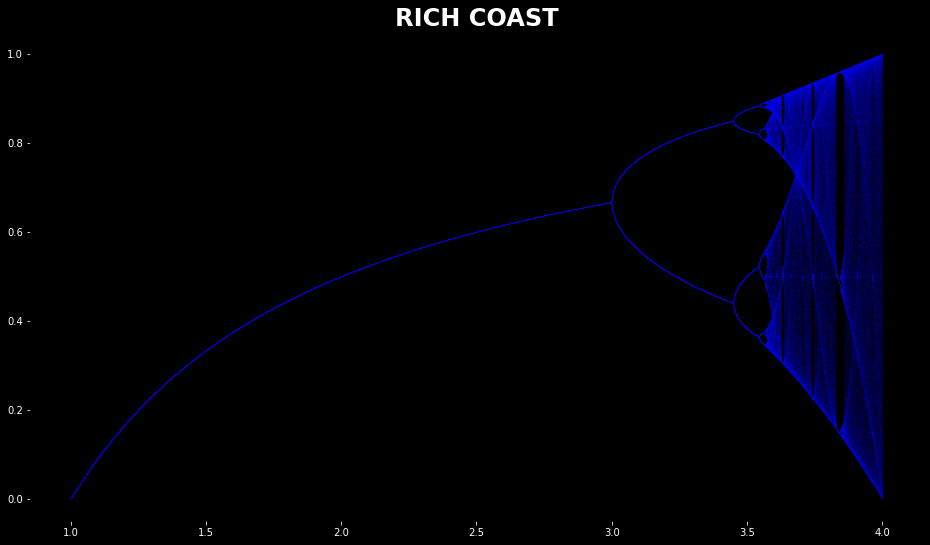

/tmp/ipykernel_351/573852659.py:39: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')


True

<Figure size 432x288 with 0 Axes>

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
interval = (1, 4)  # start, end
accuracy = 0.0001
reps = 1200  # number of repetitions
numtoplot = 200
lims = np.zeros(reps)

fig, biax = plt.subplots()
fig.set_size_inches(16, 9)

lims[0] = np.random.rand()
for r in np.arange(interval[0], interval[1], accuracy):
    for i in range(reps-1):
        lims[i+1] = r*lims[i]*(1-lims[i])

    biax.plot([r]*numtoplot, lims[reps-numtoplot:], 'b.', markersize=.02)

    
#Plot setup
fig.set_facecolor('black')
biax.set_facecolor('black')
biax.xaxis.label.set_color('white')
biax.yaxis.label.set_color('white')
biax.tick_params(axis='x', colors='white')
biax.tick_params(axis='y', colors='white')
plt.title('RICH COAST', fontsize=24, fontweight='bold', color='white', backgroundcolor='black', ha='center')

plt.show()
plt.savefig('logistic_map1.png', dpi=600)



# Get the current figure
fig = plt.gcf()

# Convert the figure to a numpy array
data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

# Save the image
cv2.imwrite('richcoast.png', data)

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

x, y = np.array(x), np.array(y)

x_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)
model = LinearRegression().fit(x_,y)

r_sq= model.score(x_,y)
y_pred = model.prediction(x_)

In [35]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

x, y = np.array(x), np.array(y)

x_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)
model = LinearRegression().fit(x_,y)

r_sq= model.score(x_,y)
y_pred = model.predict(x_)

print("model.score:", r_sq)

print("model.predict", y_pred)


model.score: 0.8850127767476205
model.predict [[3.32863816]
 [4.5425013 ]
 [4.97955248]
 [3.24282395]
 [3.80387066]
 [4.13925591]
 [4.54488605]
 [4.63031704]
 [4.43872985]
 [4.73022384]
 [4.86220753]
 [3.16312265]
 [3.35641101]
 [4.27322934]
 [4.10283525]
 [3.33523507]
 [2.983683  ]
 [4.21603149]
 [3.07895561]
 [4.27290897]
 [3.63760153]
 [3.34332385]
 [2.45598767]
 [4.07393011]
 [4.70748889]
 [3.06316812]
 [2.7338465 ]
 [3.48613738]
 [4.25006063]
 [2.97835575]
 [3.22429998]
 [3.68869554]
 [3.70841592]
 [3.75699815]
 [4.41488998]
 [4.3397952 ]
 [2.55445359]
 [2.69708548]
 [4.5113665 ]
 [3.0031198 ]
 [4.78010332]
 [4.59206586]
 [3.40261751]
 [4.02056203]
 [3.43960157]
 [3.99990524]
 [2.90759191]
 [5.03734599]
 [5.45754453]
 [4.50125371]
 [3.24552832]
 [4.28532561]
 [4.85630034]
 [4.27945012]
 [4.19929329]
 [4.23959317]
 [2.87469494]
 [5.05712344]
 [4.75934965]
 [4.90700957]
 [5.29736849]
 [4.97437419]
 [5.45448975]
 [4.41088687]
 [4.9258453 ]
 [5.14402512]
 [4.24803887]
 [3.72409336]
 [

In [26]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Define x and y
x, y = np.array(x), np.array(y)

# Create polynomial features of x
x_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)

# Fit a linear regression model to the polynomial features of x and y
model = LinearRegression().fit(x_,y)

# Calculate the R-squared value of the model on the training data
r_sq = model.score(x_,y)

# Use the trained model to predict y values for the training data
y_pred = model.predict(x_)

# Print R-squared value
print(r_sq)

# Print predicted y values
print(y_pred)


0.8975261170621521

In [63]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Definir x e y
x, y = np.array(x), np.array(y)

# Crear características polinómicas de x
x_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)

# Ajustar un modelo de regresión lineal a las características polinómicas de x e y
model = LinearRegression().fit(x_,y)

# Calcular el valor R-cuadrado del modelo en los datos de entrenamiento
r_sq = model.score(x_,y)

# Utilizar el modelo entrenado para predecir valores de y para los datos de entrenamiento
y_pred = model.predict(x_)

# Imprimir valor R-cuadrado
print("Valor R al cuadrado del modelo en los datos de entrenamiento: \n")
print(r_sq)
print("\n")
# Imprimir valores de y predichos
print("Predicciones del modelo entrenado: \n")
print(y_pred)



Valor R al cuadrado del modelo en los datos de entrenamiento: 

0.8850127767476205


Predicciones del modelo entrenado: 

[[3.32863816]
 [4.5425013 ]
 [4.97955248]
 [3.24282395]
 [3.80387066]
 [4.13925591]
 [4.54488605]
 [4.63031704]
 [4.43872985]
 [4.73022384]
 [4.86220753]
 [3.16312265]
 [3.35641101]
 [4.27322934]
 [4.10283525]
 [3.33523507]
 [2.983683  ]
 [4.21603149]
 [3.07895561]
 [4.27290897]
 [3.63760153]
 [3.34332385]
 [2.45598767]
 [4.07393011]
 [4.70748889]
 [3.06316812]
 [2.7338465 ]
 [3.48613738]
 [4.25006063]
 [2.97835575]
 [3.22429998]
 [3.68869554]
 [3.70841592]
 [3.75699815]
 [4.41488998]
 [4.3397952 ]
 [2.55445359]
 [2.69708548]
 [4.5113665 ]
 [3.0031198 ]
 [4.78010332]
 [4.59206586]
 [3.40261751]
 [4.02056203]
 [3.43960157]
 [3.99990524]
 [2.90759191]
 [5.03734599]
 [5.45754453]
 [4.50125371]
 [3.24552832]
 [4.28532561]
 [4.85630034]
 [4.27945012]
 [4.19929329]
 [4.23959317]
 [2.87469494]
 [5.05712344]
 [4.75934965]
 [4.90700957]
 [5.29736849]
 [4.97437419]
 [5.454489